# Experiments on the no2 dataset

7 input features, all continuous

No known distribution shifts in this dataset, so it is used to mimic the daily model updates.



In [1]:
import time
import os, sys, pickle, json, math, time, multiprocessing, warnings, itertools, random, warnings, gc, ast, subprocess
import copy
from collections import defaultdict, Counter, namedtuple
from math import log
from itertools import product, combinations
from random import choice, choices, sample, seed
from datetime import datetime

import gurobipy
from sklearn.metrics.pairwise import euclidean_distances
from importlib import reload
# Basics
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt

# Multi-processing
from joblib import Parallel, delayed
from tqdm import tqdm

# sci-kit learn
import sklearn
import sklearn.datasets as datasets
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, make_scorer
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve
from utilexp import *

pd.options.display.max_columns = 100
pd.options.display.max_rows = 150
from utilexp import *
import warnings

warnings.filterwarnings('ignore')
from expnns.preprocessor import Preprocessor, min_max_scale


In [2]:
df = pd.read_csv("../datasets/no2/no2.csv")
df = df.dropna()
df = df.replace(to_replace={'N': 0, 'P': 1})
ordinal_features = {}
discrete_features = {}
continuous_features = list(df.columns)[:-1]
CLASS = "binaryClass"

# min max scale
min_vals = np.min(df[continuous_features], axis=0)
max_vals = np.max(df[continuous_features], axis=0)
df_mm = min_max_scale(df, continuous_features, min_vals, max_vals)
columns = list(df_mm.columns)
display(df_mm)
# get X, y
X, y = df_mm.drop(columns=['binaryClass']), pd.DataFrame(df_mm['binaryClass'])

SPLIT = .2
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=SPLIT, shuffle=True,
                                                    random_state=0)
feat_var_map = {}
for i in range(len(X.columns)):
    feat_var_map[i] = [i]

,no2_concentration,cars_per_hour,temperature_at_2m,wind_speed,temperature_diff_2m_25m,wind_direction,hour_of_day,binaryClass
0,0.482404,0.844284,0.700252,0.468750,0.546392,0.202801,0.826087,0
1,0.362831,0.846118,0.629723,0.333333,0.525773,0.151261,0.565217,1
2,0.404232,0.162280,0.375315,0.062500,0.546392,0.782353,0.130435,0
3,0.611930,0.669122,0.287154,0.145833,0.680412,0.201681,0.956522,1
4,0.603835,0.803270,0.435768,0.239583,0.546392,0.176471,0.434783,1
...,...,...,...,...,...,...,...,...
495,0.596692,0.842110,0.556675,0.489583,0.453608,0.212885,0.434783,1
496,0.332732,0.569073,0.707809,0.645833,0.474227,0.582633,0.391304,1
497,0.570573,0.860087,0.599496,0.447917,0.474227,0.593838,0.565217,1
498,0.334757,0.393904,0.680101,0.020833,0.288660,0.298319,0.260870,0


In [3]:
X1, X2 = X[:250], X[250:]
y1, y2 = y[:250], y[250:]
SPLIT = .2
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, stratify=y1, test_size=SPLIT, shuffle=True,
                                                        random_state=0)


# Train models and Observe model shifts


In [ ]:
# Randomdised search + 5-fold cross validation (default)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier

nn = MLPClassifier(learning_rate='adaptive', random_state=0)

# parameters
max_iter_vals = [int(i) for i in np.linspace(1000, 10000, 10)]
hidden_layer_sizes_vals = [(i) for i in range(5, 25)]
batch_size_vals = [8, 16, 32, 64]
learning_rate_init_vals = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05]

#distributions = dict(max_iter=max_iter_vals, hidden_layer_sizes=hidden_layer_sizes_vals)
distributions = dict(hidden_layer_sizes=hidden_layer_sizes_vals,
                     batch_size=batch_size_vals,
                     learning_rate_init=learning_rate_init_vals,
                     max_iter=max_iter_vals, )

#nns = RandomizedSearchCV(nn, distributions, scoring='f1_macro')
nns = RandomizedSearchCV(nn, distributions, scoring='accuracy')
search = nns.fit(X, y)
print(search.best_params_)


In [4]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(learning_rate='adaptive', hidden_layer_sizes=13, learning_rate_init=0.02, batch_size=32,
                    max_iter=7000, random_state=0)

# 5-fold cross validation
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score, f1_score, precision_score

scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
scores = cross_validate(clf, X, y, scoring=scoring)
for name in list(scores.keys()):
    if name == 'fit_time' or name == 'score_time':
        continue
    print("%0.2f %s with a std of %0.2f" % (scores[name].mean(), name, scores[name].std()))

clf = MLPClassifier(learning_rate='adaptive', hidden_layer_sizes=13, learning_rate_init=0.02, batch_size=32,
                    max_iter=7000, random_state=0)

clf.fit(X1_train, y1_train)
resres = clf.predict(X1_test.values)
print('\n', classification_report(y1_test, resres, target_names=[f'bad credit (0)', f'good credit (1)'], digits=3))
resres = clf.predict(X.values)
print('\n', classification_report(y, resres, target_names=[f'bad credit (0)', f'good credit (1)'], digits=3))


0.61 test_accuracy with a std of 0.02
0.61 test_precision_macro with a std of 0.02
0.61 test_recall_macro with a std of 0.03
0.60 test_f1_macro with a std of 0.03

                  precision    recall  f1-score   support

 bad credit (0)      0.565     0.542     0.553        24
good credit (1)      0.593     0.615     0.604        26

       accuracy                          0.580        50
      macro avg      0.579     0.579     0.578        50
   weighted avg      0.579     0.580     0.579        50


                  precision    recall  f1-score   support

 bad credit (0)      0.645     0.643     0.644       249
good credit (1)      0.647     0.649     0.648       251

       accuracy                          0.646       500
      macro avg      0.646     0.646     0.646       500
   weighted avg      0.646     0.646     0.646       500



In [10]:
from joblib import dump, load

#dump(clf, 'no2.joblib')


['no2.joblib']

inf-distance for weights and biases of classifiers with hidden size [ 4  6  8 10 12 14 16 18 20], training gap is 0.05, 
WEIGHTS or BIASES inf-distance /// % of D2 used


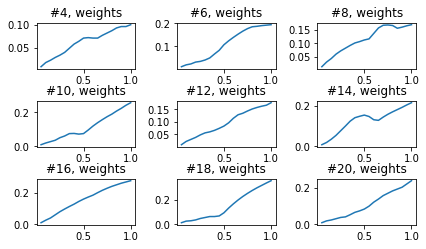

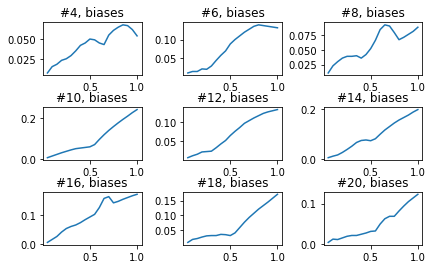

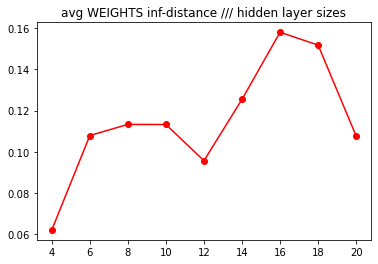

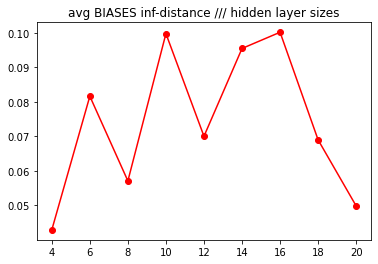

In [5]:
# inf-distance for weights and biases of classifiers with hidden size [ 4  6  8 10 12 14 16 18 20]
# training gap is 0.05

train_gap = 0.05
h_hidden_size = np.arange(4, 21, 2)
lr = 0.02
batch_size = 32
max_iter = 7000
avg_w_dists_wrt_sizes, avg_b_dists_wrt_sizes = plot_incremental_training_weight_bias_changes(train_gap, h_hidden_size,
                                                                                             lr, batch_size, max_iter,
                                                                                             X1, y1, X2, y2,
                                                                                             False)


inf-distance for weights and biases of classifiers with hidden size [ 4  6  8 10 12 14 16 18 20], training gap is 0.02, 
WEIGHTS or BIASES inf-distance /// % of D2 used


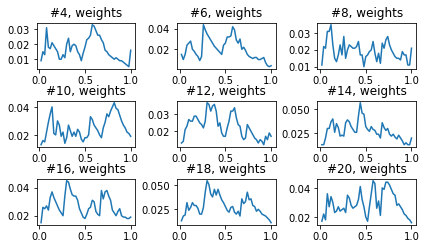

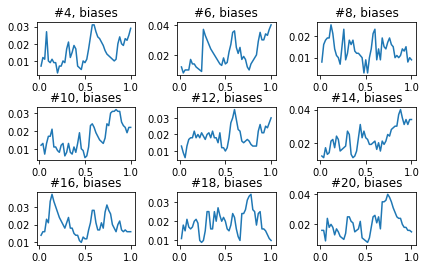

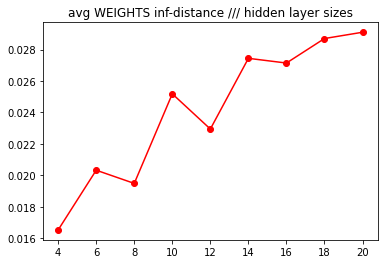

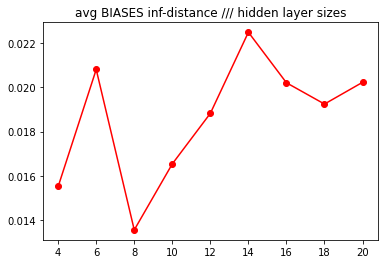

inf-distance for weights and biases of classifiers with hidden size [ 4  6  8 10 12 14 16 18 20], training gap is 0.05, 
WEIGHTS or BIASES inf-distance /// % of D2 used


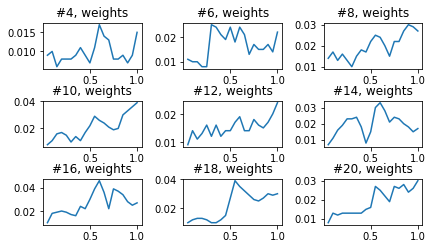

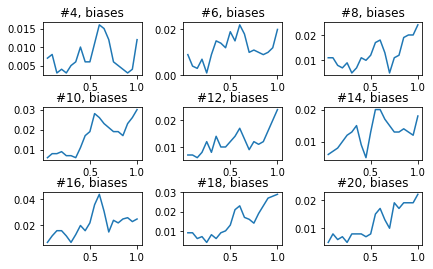

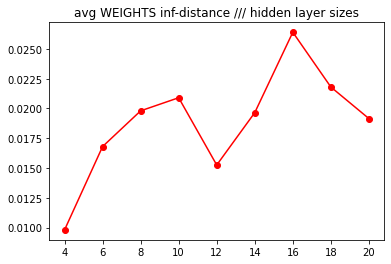

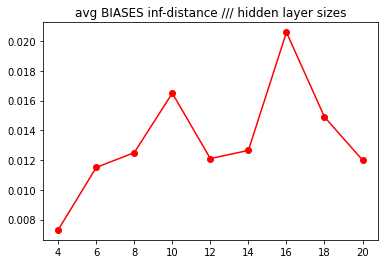

inf-distance for weights and biases of classifiers with hidden size [ 4  6  8 10 12 14 16 18 20], training gap is 0.1, 
WEIGHTS or BIASES inf-distance /// % of D2 used


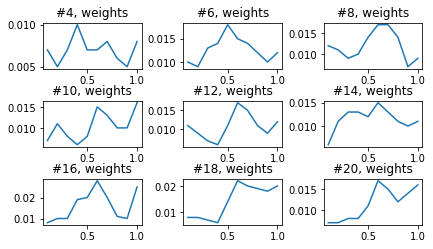

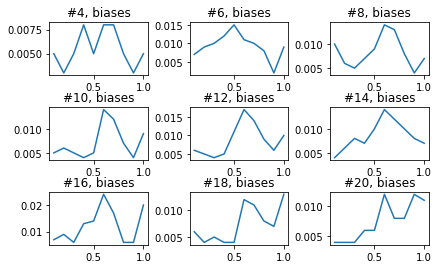

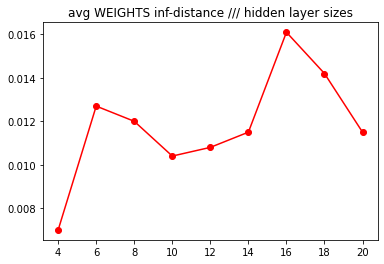

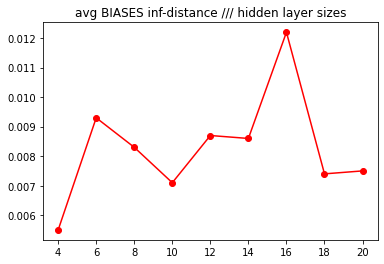

inf-distance for weights and biases of classifiers with hidden size [ 4  6  8 10 12 14 16 18 20], training gap is 0.2, 
WEIGHTS or BIASES inf-distance /// % of D2 used


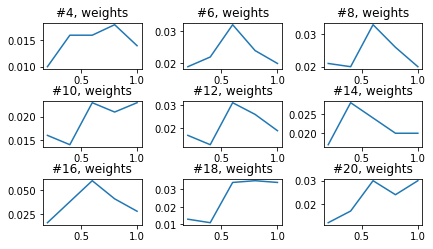

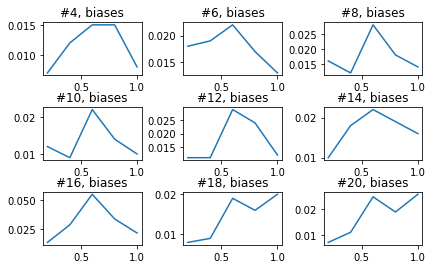

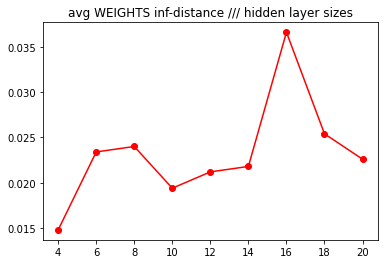

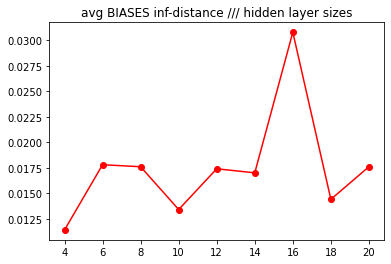

inf-distance for weights and biases of classifiers with hidden size [ 4  6  8 10 12 14 16 18 20], training gap is 0.25, 
WEIGHTS or BIASES inf-distance /// % of D2 used


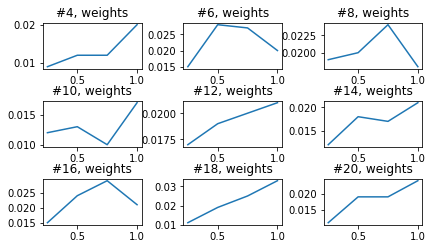

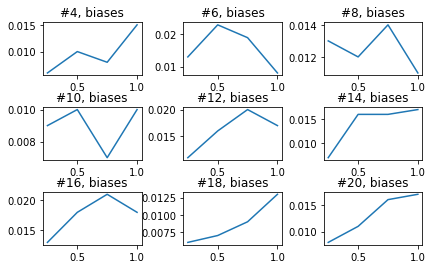

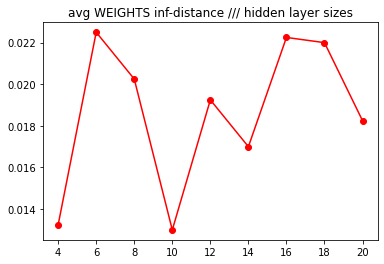

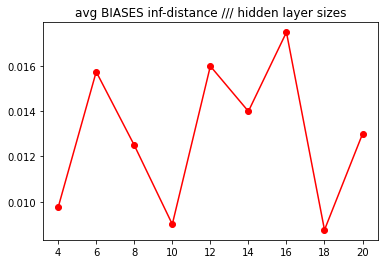

In [13]:
# inf-distance for weights and biases of classifiers with hidden size [ 4  6  8 10 12 14 16 18 20]
# training gap is [0.02, 0.05, 0.10, 0.20]

train_gaps = [0.02, 0.05, 0.10, 0.20, 0.25]
h_hidden_size = np.arange(4, 21, 2)
lr = 0.02
batch_size = 32
max_iter = 7000

avg_w_dists_wrt_gaps = []
avg_b_dists_wrt_gaps = []
for gap in train_gaps:
    thisw, thisb = plot_incremental_training_weight_bias_changes(gap, h_hidden_size,
                                                                 lr, batch_size, max_iter,
                                                                 X1, y1, X2, y2)
    avg_w_dists_wrt_gaps.append(thisw)
    avg_b_dists_wrt_gaps.append(thisb)


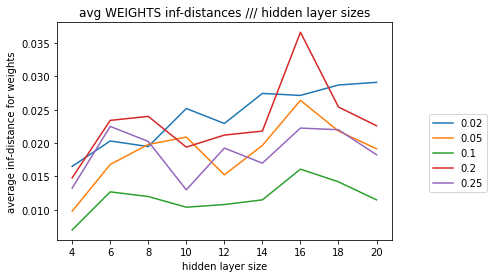

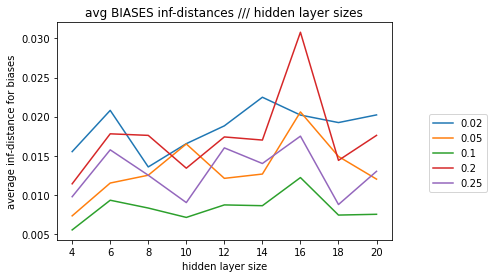

In [14]:
plt.figure(5)
plt.xlabel("hidden layer size")
plt.ylabel("average inf-distance for weights")
for i, item in enumerate(avg_w_dists_wrt_gaps):
    plt.plot(h_hidden_size, item, label=f"{train_gaps[i]}")
plt.legend(bbox_to_anchor=(1.3, 0.6))
plt.title('avg WEIGHTS inf-distances /// hidden layer sizes')

plt.figure(6)
plt.xlabel("hidden layer size")
plt.ylabel("average inf-distance for biases")
for i, item in enumerate(avg_b_dists_wrt_gaps):
    plt.plot(h_hidden_size, item, label=f"{train_gaps[i]}")
plt.legend(bbox_to_anchor=(1.3, 0.6))
plt.title('avg BIASES inf-distances /// hidden layer sizes')
plt.show()


# Experiments: computing counterfactuals

#### Procedures

These procedures are covered by UtilExp class

1. Train M on D1
2. Get delta-min, build M+ and M-: incrementally train M 5 times, using different 10% of D2 each time, then get the maximum inf-distance between the incremented models and M. Construct M+ and M- using delta-min
3. Get M2: incrementally train M on D2
4. Select test instances: randomly select 50 D1 instances to explain, clf(x)=0, desired class=1
5. Report metrics using each baseline

#### Metrics
- Proximity: normalised L1: "Scaling Guarantees for Nearest CEs" page 7
- Sparsity: L0
- Validity-delta: percentage of test instances that 1) have counterfactuals valid on m1, 2) counterfactuals valid on M+ and M- under delta_min
- Validity-m2: percentage of test instances that 1) have counterfactual(s), 2) these counterfactual(s) are all valid on both m1 and m2
- LOF: average LOF score

In [4]:
from joblib import dump, load

clf = load("no2.joblib")

gurobipy.setParam("FeasibilityTol", 1e-09)
gurobipy.setParam("OptimalityTol", 1e-09)
gurobipy.setParam("IntFeasTol", 1e-05)


Set parameter Username
Academic license - for non-commercial use only - expires 2023-06-14
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09


In [7]:
util_exp = UtilExp(clf, X1, y1, X2, y2, columns, ordinal_features, discrete_features, continuous_features, feat_var_map, num_test_instances=300, gap=0.3)
print(util_exp.delta_max)
print(util_exp.delta_min)


0.0946905663037858
0.03426087680984713


In [8]:
valids = util_exp.verify_soundness()
print(len(valids))

percentage of sound model changes: 0.36885245901639346
45


In [9]:
valids = util_exp.verify_soundness(update_test_instances=True)

percentage of sound model changes: 0.36885245901639346
test instances updated to sound (x, Delta) pairs, length: 45


In [6]:
# OURS-ROBUST
ours_robust_ces = util_exp.run_ours_robust()
util_exp.evaluate_ces(ours_robust_ces)

15it [00:00, 21.10it/s]

total computation time in s: 0.7130565643310547
found: 1.0
average normalised L1: 0.0359573364442214
average normalised L0: 0.1906666666666666
average lof score: 1.0
counterfactual validity: 1.0
delta validity: 1.0
m2 validity: 1.0


In [10]:
# OURS-NON-ROBUST
ours_non_robust_ces = util_exp.run_ours_non_robust()
util_exp.evaluate_ces(ours_non_robust_ces)

45it [00:00, 116.58it/s]


total computation time in s: 0.3890378475189209
found: 1.0
average normalised L1: 0.03899720309125543
average normalised L0: 0.1525333333333332
average lof score: 1.0
counterfactual validity: 1.0
delta validity: 0.0
m2 validity: 1.0


In [11]:
# ROAR
roar_ces = util_exp.run_ROAR(labels=(1,))
util_exp.evaluate_ces(roar_ces)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  2.36it/s]

0it [00:00, ?it/s]
1it [00:00,  2.33it/s]

0it [00:00, ?it/s]
1it [00:00,  2.60it/s]

0it [00:00, ?it/s]
1it [00:00,  2.71it/s]

0it [00:00, ?it/s]
1it [00:00,  3.45it/s]

0it [00:00, ?it/s]
1it [00:00,  4.10it/s]

0it [00:00, ?it/s]
1it [00:00,  4.88it/s]

0it [00:00, ?it/s]
1it [00:00,  4.98it/s]

0it [00:00, ?it/s]
1it [00:00,  4.31it/s]

0it [00:00, ?it/s]
1it [00:00,  5.88it/s]

0it [00:00, ?it/s]
1it [00:00,  8.00it/s]

1it [00:00, 10.99it/s]
1it [00:03,  3.34s/it]
0it [00:00, ?it/s]
1it [00:00,  2.92it/s]

0it [00:00, ?it/s]
1it [00:00,  2.99it/s]

0it [00:00, ?it/s]
1it [00:00,  3.08it/s]

0it [00:00, ?it/s]
1it [00:00,  2.79it/s]

0it [00:00, ?it/s]
1it [00:00,  4.05it/s]

0it [00:00, ?it/s]
1it [00:00,  5.15it/s]

0it [00:00, ?it/s]
1it [00:00,  5.88it/s]

0it [00:00, ?it/s]
1it [00:00,  6.80it/s]

0it [00:00, ?it/s]
1it [00:00,  7.57it/s]
2it [00:05,  2.80s/it]
0it [00:00, ?it/s]
1it [00:00,  1.97it/s]

0it [00:00

total computation time in s: 130.3766348361969
found: 1.0
average normalised L1: 0.06429367265029737
average normalised L0: 0.8826666666666663
average lof score: 1.0
counterfactual validity: 0.8666666666666667
delta validity: 0.0
m2 validity: 0.8666666666666667


In [11]:
# ROAR-robustness-boosted
roar_ces_robust = util_exp.run_ROAR(labels=(1,), robust=True, lamb1_mul=2)
util_exp.evaluate_ces(roar_ces_robust)
# lamb1 *= 2, count 10

0it [00:00, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  3.10it/s]

0it [00:00, ?it/s]
1it [00:00,  2.91it/s]

0it [00:00, ?it/s]
1it [00:00,  2.87it/s]

0it [00:00, ?it/s]
1it [00:00,  3.01it/s]

0it [00:00, ?it/s]
1it [00:00,  4.24it/s]

0it [00:00, ?it/s]
1it [00:00,  5.65it/s]

0it [00:00, ?it/s]
1it [00:00,  6.41it/s]

0it [00:00, ?it/s]
1it [00:00,  6.17it/s]

1it [00:00, 10.53it/s]

1it [00:00, 13.70it/s]

1it [00:00, 13.16it/s]

1it [00:00, 35.71it/s]
1it [00:02,  2.48s/it]
0it [00:00, ?it/s]
1it [00:00,  2.40it/s]

0it [00:00, ?it/s]
1it [00:00,  2.44it/s]

0it [00:00, ?it/s]
1it [00:00,  2.53it/s]

0it [00:00, ?it/s]
1it [00:00,  2.71it/s]

0it [00:00, ?it/s]
1it [00:00,  3.30it/s]

0it [00:00, ?it/s]
1it [00:00,  3.91it/s]

0it [00:00, ?it/s]
1it [00:00,  4.76it/s]

0it [00:00, ?it/s]
1it [00:00,  4.88it/s]

0it [00:00, ?it/s]
1it [00:00,  4.20it/s]

0it [00:00, ?it/s]
1it [00:00,  5.68it/s]

0it [00:00, ?it/s]
1it [00:00,  8.20it/s]

1it [00:00, 11.24it/s]
2it [00:25, 14.44s/it]


total computation time in s: 155.76112127304077
found: 1.0
average normalised L1: 0.05217221335522498
average normalised L0: 0.8795789473684209
average lof score: 1.0
counterfactual validity: 0.95
delta validity: 0.7
m2 validity: 0.95


In [12]:
# PROTOTYPES
proto_ces = util_exp.run_proto(kap=0)
util_exp.evaluate_ces(proto_ces)

No encoder specified. Using k-d trees to represent class prototypes.
45it [12:22, 16.50s/it]


total computation time in s: 742.5490005016327
found: 1.0
average normalised L1: 0.04063982272018782
average normalised L0: 0.43188888888888877
average lof score: 1.0
counterfactual validity: 1.0
delta validity: 0.0
m2 validity: 1.0


In [7]:
# PROTOTYPES-robustness-boosted
proto_ces_robust = util_exp.run_proto_robust(proto_ces)
util_exp.evaluate_ces(proto_ces_robust)

0it [00:00, ?it/s]No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class prototypes.
1it [00:56, 56.07s/it]No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class protot

total computation time in s: 592.8469998836517
found: 1.0
average normalised L1: 0.032596718899400835
average normalised L0: 0.4570999999999999
average lof score: 1.0
counterfactual validity: 1.0
delta validity: 0.0
m2 validity: 1.0


In [13]:
# WACHTER CF
wachter_ces = util_exp.run_wachter(target_proba=0.57, max_lam_steps=10)
util_exp.evaluate_ces(wachter_ces)


45it [05:19,  7.09s/it]


total computation time in s: 319.11905241012573
found: 1.0
average normalised L1: 0.042914743051922305
average normalised L0: 0.8983111111111108
average lof score: 1.0
counterfactual validity: 1.0
delta validity: 0.0
m2 validity: 1.0


In [10]:
# WACHTER CF - robustness-boosted
wachter_ces_rob = util_exp.run_wachter_robust()
util_exp.evaluate_ces(wachter_ces_rob)


30it [00:58,  1.96s/it]


total computation time in s: 58.80599880218506
found: 1.0
average normalised L1: 0.2681282685696651
average normalised L0: 0.9952333333333333
average lof score: -1.0
counterfactual validity: 1.0
delta validity: 1.0
m2 validity: 1.0


In [14]:
delta = util_exp.delta_max
print(np.arange(delta/10, delta*1.01, delta/10))
plot_x = np.arange(0.0, 1.01, 0.1)
print(delta)
print(plot_x)


[0.00946906 0.01893811 0.02840717 0.03787623 0.04734528 0.05681434
 0.0662834  0.07575245 0.08522151 0.09469057]
0.0946905663037858
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [15]:
def evaluate_ces_validity_plot(test_instances, ces, target_delta=0.05):
    deltas = np.concatenate((np.array([0]),np.arange(target_delta/10, target_delta*1.01, target_delta/10)))
    delta_vals = []
    for delta in deltas:
        delta_val = 0
        nodes = build_inn_nodes(util_exp.clf, util_exp.num_layers)
        weights, biases = build_inn_weights_biases(util_exp.clf, util_exp.num_layers, delta, nodes)
        inn_delta = Inn(util_exp.num_layers, delta, nodes, weights, biases)
        for i, x in enumerate(test_instances):
            if ces[i] is None:
                continue
            y_prime = 1 if util_exp.clf.predict(x.reshape(1, -1))[0] == 0 else 0
            this_solver = OptSolver(util_exp.dataset, inn_delta, y_prime, x, mode=1, M=10000, x_prime=ces[i])
            if this_solver.compute_inn_bounds()[0] == 1:
                delta_val += 1
        delta_vals.append(delta_val / len(test_instances))
    return delta_vals


In [16]:
delta_vals_roar = evaluate_ces_validity_plot(util_exp.test_instances, roar_ces, target_delta=util_exp.delta_min)
delta_vals_ours_non_rob = evaluate_ces_validity_plot(util_exp.test_instances, ours_non_robust_ces,
                                                     target_delta=util_exp.delta_min)
delta_vals_wachter = evaluate_ces_validity_plot(util_exp.test_instances, wachter_ces, target_delta=util_exp.delta_min)
delta_vals_proto = evaluate_ces_validity_plot(util_exp.test_instances, proto_ces, target_delta=util_exp.delta_min)

In [17]:
plot_x = [str(i) + "*$\delta$" for i in np.round(np.arange(0., 1.00001, 0.1), 1)]
print(plot_x)
plot_x_num = np.round(np.arange(0, 1.00001, 0.1), 1)

['0.0*$\\delta$', '0.1*$\\delta$', '0.2*$\\delta$', '0.3*$\\delta$', '0.4*$\\delta$', '0.5*$\\delta$', '0.6*$\\delta$', '0.7*$\\delta$', '0.8*$\\delta$', '0.9*$\\delta$', '1.0*$\\delta$']


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


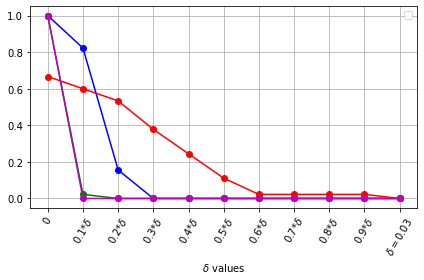

In [23]:
fig, ax = plt.subplots()
ax.plot(plot_x_num, delta_vals_wachter, "bo-")#, label="WACHTER")
ax.plot(plot_x_num, delta_vals_proto, "go-")#, label="PROTO")
ax.plot(plot_x_num, delta_vals_roar, "ro-")#, label="ROAR")
ax.plot(plot_x_num, delta_vals_ours_non_rob, "mo-")#, label="MILP")
ax.set_xticks(np.arange(0., 1.01, 0.1))
labels = [item.get_text() for item in ax.get_xticklabels()]
for i in range(len(labels)):
    labels[i] = plot_x[i]
    if i == len(labels) - 1:
        labels[i] = "$\delta=$" + str(np.round(util_exp.delta_min, 2))
    if i == 0:
        labels[i] = str(0)
ax.set_xticklabels(labels)
ax.grid()
ax.legend()
plt.xticks(rotation=60)
#ax.set_ylabel("$\delta$-validity")
ax.set_xlabel("$\delta$ values")
fig.tight_layout()
fig.savefig("./plots/delta-val-no2.png", dpi=300)